In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('Gold Price (2013-2023).csv')

def convert_volume(vol):
    if pd.isna(vol) or vol == '':
        return np.nan
    vol = vol.replace(',', '')
    if vol.endswith('K'):
        return float(vol[:-1]) * 1_000
    if vol.endswith('M'):
        return float(vol[:-1]) * 1_000_000
    return float(vol)

def preprocess_data(df):
    df = df.copy()

    # Date
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    df.set_index('Date', inplace=True)

    # Convert numeric columns (except Vol., Change %)
    price_cols = ['Price', 'Open', 'High', 'Low']
    for col in price_cols:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(',', '')
            .astype(float)
        )
    
    df['Vol.'] = df['Vol.'].apply(convert_volume)

    df = df.asfreq('B')

    # Target
    df['Target'] = df['Price'].shift(-1)

    # Handle missing values
    df.replace(0, np.nan, inplace=True)
    df = df.interpolate(method='time').ffill().bfill()

    return df

target = 'Target'
df = preprocess_data(df)
train_size = int(len(df) * 0.9)
train, test = df.iloc[:train_size], df.iloc[train_size:]

def get_metrics(true, pred, name):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = mean_absolute_percentage_error(true, pred) * 100
    r2 = r2_score(true, pred)
    print(f"[{name}] RMSE: {rmse:.2f}, MAPE: {mape:.2f}%, R2: {r2:.4f}")
    return [rmse, mape, r2]

print(f"Pipeline ready. Train: {len(train)}, Test: {len(test)}")

Pipeline ready. Train: 2347, Test: 261


C:\Users\hoang\AppData\Local\Temp\ipykernel_9580\2896392956.py:47: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='time').ffill().bfill()


In [18]:
def get_features(history_df):
    """Calculates features for the most recent point in the provided history."""
    recent = history_df.tail(60).copy()
    
    # Indicators
    ma10 = recent[target].rolling(window=10).mean().iloc[-1]
    ma50 = recent[target].rolling(window=50).mean().iloc[-1]
    
    # RSI calculation
    delta = recent[target].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean().iloc[-1]
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean().iloc[-1]
    rsi = 100 - (100 / (1 + (gain/loss))) if loss != 0 else 50
    
    last = recent.iloc[-1]
    return np.array([last['Open'], last['High'], last['Low'], last['Vol.'], ma10, ma50, rsi]).reshape(1, -1)

# Base features for initial training
def prepare_static_features(data_df):
    temp = data_df.copy()
    temp['MA10'] = temp[target].rolling(10).mean()
    temp['MA50'] = temp[target].rolling(50).mean()
    delta = temp[target].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    temp['RSI'] = 100 - (100 / (1 + (gain/loss)))
    temp = temp.dropna()
    features = ['Open', 'High', 'Low', 'Vol.', 'MA10', 'MA50', 'RSI']
    return temp[features], temp[target]

X_static, y_static = prepare_static_features(train)

d:\Project 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\Project 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\Project 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\Project 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\Project 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\Project 1\venv\Lib\site-packages\sklearn\utils\validation

[Linear Regression] RMSE: 22.25, MAPE: 0.96%, R2: 0.9407


d:\Project 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\Project 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\Project 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\Project 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\Project 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\Project 1\venv\Lib\site-packages\sklearn\utils\validation

Text(0.5, 1.0, 'Linear Regression')

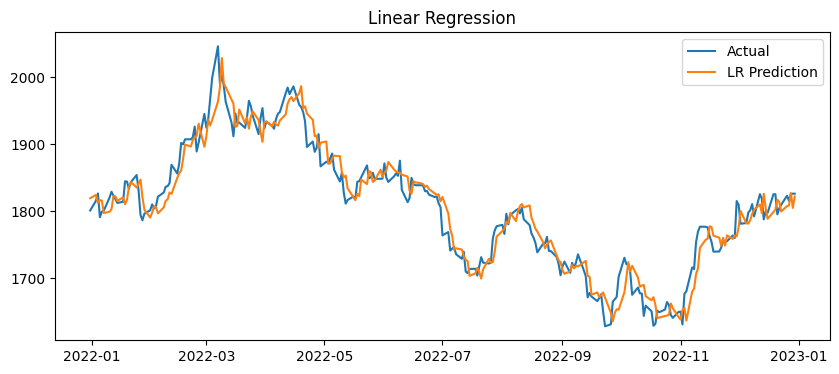

In [19]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression().fit(X_static, y_static)
lr_preds = []
history = train.copy()

for i in range(len(test)):
    X_curr = get_features(history)
    lr_preds.append(lr_model.predict(X_curr)[0])
    history = pd.concat([history, test.iloc[[i]]])

lr_res = get_metrics(test[target], lr_preds, "Linear Regression")

plt.figure(figsize=(10, 4))
plt.plot(test.index, test[target], label='Actual')
plt.plot(test.index, lr_preds, label='LR Prediction')
plt.legend()
plt.title("Linear Regression")